In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

### First, let's prepare the data

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

#Creating final dataset
data = pd.merge(specs[['ID_library', 'smiles']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data = data.drop([5164]) #Removing the compound whose SMILES has an error
print(f"There are {len(data)} rows in data")

There are 5171 rows in data


Remove duplicated columns

In [3]:
# Look for duplicated columns
dup_cols = fun.getDuplicateColumns(sss_batchA)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['Location_Center_Y_cytoplasm', 'Location_Center_Y_cells', 'Location_Center_X_nuclei', 'AreaShape_BoundingBoxArea_cytoplasm', 'Location_Center_Y_nuclei', 'AreaShape_MinFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'Intensity_MeanIntensity_illumMITO_cells.1', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'AreaShape_MaxFeretDiameter_cytoplasm', 'Location_Center_X_cytoplasm', 'Location_Center_X_cells', 'AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm']


In [5]:
# I need to keep Intensity_MeanIntensity_illumMITO_cells.1 for later computations
iaux = dup_cols.index("Intensity_MeanIntensity_illumMITO_cells.1")
dup_cols[iaux]= 'Intensity_MeanIntensity_illumMITO_cells'

In [6]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(dup_cols, axis=1)

Removing not useful columns (according to Jonne)

In [7]:
filter_col = [col for col in sss_batchA.columns if 'MITO' in col]
print(f'There are {len(filter_col)} columns containig info about MITO')

There are 364 columns containig info about MITO


In [9]:
filter_col = filter_col[:-1] # IF Intensity_MeanIntensity_illumMITO_cells.1 is in the last position

In [10]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(filter_col, axis=1)

### Now we add the information for training + cleaning

First the cell profiler

In [11]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Intensity_MeanIntensity_illumMITO_cells.1','Ypredicted','Labels'], 1)
#Create a vector that takes only the info from the cell profiler. NOTE: it is important to keep the ID intact for future merging
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)

<ipython-input-11-f8daa7d32177>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Intensity_MeanIntensity_illumMITO_cells.1','Ypredicted','Labels'], 1)


In [12]:
#Creating final dataset
data = pd.merge(data, cell_profiler[['ID_covid', 'cell_profiler_vector']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,cell_profiler_vector
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"[177.625, 1720.288161, 2334.18884, 1099.896167..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"[205.4444444, 1688.236028, 2286.442354, 1091.8..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"[204.7777778, 1708.759477, 2319.240635, 1091.1..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"[193.8888889, 1647.879668, 2244.319157, 1201.7..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"[200.2222222, 1667.427461, 2269.049919, 1138.2..."


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_library                                 5171 non-null   object 
 1   smiles                                     5171 non-null   object 
 2   Intensity_MeanIntensity_illumMITO_cells.1  5171 non-null   float64
 3   cell_profiler_vector                       5171 non-null   object 
dtypes: float64(1), object(3)
memory usage: 202.0+ KB


In [14]:
# Compounds with volume 0
compound_volume0 = ['CBK309099','CBK290175','CBK290175','CBK290175','CBK290175','CBK308178','CBK308178','CBK308178','CBK308178',
                    'CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309392',
                    'CBK309392','CBK290631','CBK309251','CBK309251','CBK309251','CBK309251','CBK290950','CBK290950','CBK290950','CBK290950']

compound_volume0_idx = [data.index[data['ID_library'] == comp].to_list() for comp in compound_volume0]
compound_volume0_idx = [item for sublist in compound_volume0_idx for item in sublist]

In [15]:
data = data.drop(compound_volume0_idx)

### Now training

In [17]:
# We get the input values
X = data['cell_profiler_vector'].tolist()
X = np.asarray(X)
# Output values
y = data['Intensity_MeanIntensity_illumMITO_cells.1'].values
# Re-scale
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = 1000*y

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25435)

In [19]:
# Training
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
# Computing predictions
y_pred = regressor.predict(X_test)
# Accessing results
#df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print('Mean squared logarithmic error regression loss:', mean_squared_log_error(y_test, y_pred)) 

Mean squared logarithmic error regression loss: 0.003912486174831925


In [22]:
results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

In [23]:
results

,Actual,Predicted
0,9.341117,9.952406
1,8.872410,9.796538
2,8.086758,8.265380
3,8.963924,9.669082
4,8.439369,9.354256
...,...,...
1028,8.565198,8.770846
1029,8.670769,7.183172
1030,10.006713,9.799321
1031,7.816026,7.729898


In [32]:
results = fun.labelling_v2(results, col_reference='Actual', labels_position = 1, label_positive=1, label_negative=0, threshold=6.2)
results = fun.labelling_v2(results, col_reference='Predicted', labels_position = 3, label_positive=1, label_negative=0, threshold=6.2)

In [33]:
results

,Actual,Labels_Actual,Predicted,Labels_Predicted
0,9.341117,0,9.952406,0
1,8.872410,0,9.796538,0
2,8.086758,0,8.265380,0
3,8.963924,0,9.669082,0
4,8.439369,0,9.354256,0
...,...,...,...,...
1028,8.565198,0,8.770846,0
1029,8.670769,0,7.183172,0
1030,10.006713,0,9.799321,0
1031,7.816026,0,7.729898,0


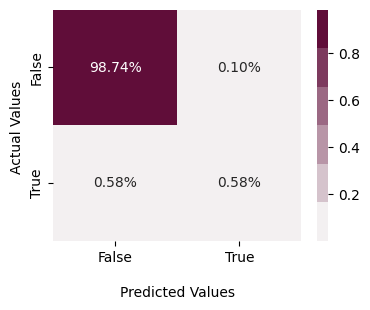

In [35]:
cd_mo = confusion_matrix(results['Labels_Actual'].tolist(), results['Labels_Predicted'].tolist())
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = sns.heatmap(cd_mo/np.sum(cd_mo), annot=True, fmt = '.2%', cmap=sns.light_palette((.376, .051, .224)), ax=ax)
#ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()